# Building an E2E Computer Vision ML Pipeline with Amazon Rekognition
#### Author: Yi-Hsuan Kuo  

It's a complete computer vision pipeline, including:
- Dataset preparation and storage.
- Model training using Amazon Rekognition Custom Labels.
- Testing the trained model on unseen data.
- Performing inference using manual interaction with the Rekognition API.

## Dataset Description and Labeling Process
The dataset used in this project was collected manually from https://www.pexels.com/.  
Two categories were selected for classification: Ccat and dog. For each category, 20 representative images were downloaded, resulting in a total of 40 images in the dataset.  

To prepare the data for training, all images were uploaded to an Amazon S3 bucket created specifically for this project. The images were then labeled using the Amazon Rekognition Custom Labels interface. Each image was manually assigned to one of the three classes based on its content. The labeling process ensured that all classes had an equal number of images to maintain balance during training.


In [1]:
# Examine image shape
import os
from PIL import Image

def check_image_shapes(folder_path):
    shapes = {}
    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            file_path = os.path.join(folder_path, file_name)
            try:
                with Image.open(file_path) as img:
                    shapes[file_name] = img.size[::-1] + ((len(img.getbands())),)
                    # img.size gives (width, height), we reverse to (height, width)
            except Exception as e:
                shapes[file_name] = f"Error: {e}"
    return shapes


folder = 'data/dog'
shapes = check_image_shapes(folder)

for name, shape in shapes.items():
    print(f"{name}: {shape}")


folder = 'data/cat'
shapes = check_image_shapes(folder)

for name, shape in shapes.items():
    print(f"{name}: {shape}")

dog20.jpg: (3456, 5184, 3)
dog1.jpg: (3888, 5184, 3)
dog7.jpg: (3456, 5184, 3)
dog19.jpg: (5176, 4000, 3)
dog5.jpg: (3306, 2888, 3)
dog14.jpg: (2560, 1707, 3)
dog16.jpg: (4150, 3456, 3)
dog17.jpg: (3648, 5004, 3)
dog18.jpg: (2592, 3872, 3)
dog8.jpg: (4000, 6000, 3)
dog11.jpg: (1843, 3276, 3)
dog12.jpg: (3456, 5184, 3)
dog10.jpg: (3456, 5184, 3)
dog3.jpg: (1365, 2048, 3)
dog13.jpg: (6000, 4000, 3)
dog6.jpg: (3456, 4608, 3)
dog2.jpg: (6306, 4204, 3)
dog15.jpg: (2000, 3000, 3)
dog9.jpg: (5184, 3456, 3)
dog4.jpg: (4032, 3024, 3)
cat10.jpg: (3010, 4896, 3)
cat5.jpg: (2304, 3456, 3)
cat12.jpg: (1944, 2592, 3)
cat13.jpg: (3200, 4800, 3)
cat2.jpg: (3560, 5360, 3)
cat14.jpg: (3696, 2765, 3)
cat1.jpg: (2592, 3888, 3)
cat19.jpg: (4016, 6016, 3)
cat18.jpg: (6016, 4000, 3)
cat4.jpg: (1704, 2557, 3)
cat20.jpg: (1728, 2480, 3)
cat3.jpg: (2657, 1771, 3)
cat17.jpg: (3072, 4608, 3)
cat8.jpg: (3266, 4899, 3)
cat11.jpg: (2916, 5184, 3)
cat16.jpg: (4000, 6000, 3)
cat9.jpg: (2667, 4000, 3)
cat6.jpg: (3602, 

#### We found while we train models using original pictures, there's an error message: "The manifest file contains too many invalid rows.". Therefore, we clean images first.
![train_error](screenshots/train_error.png)

In [2]:
from PIL import Image
import os

def clean_images(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            try:
                img = Image.open(os.path.join(input_folder, filename))
                img = img.convert("RGB")  
                img = img.resize((400, 400))  
                img.save(os.path.join(output_folder, filename), format='JPEG')
            except Exception as e:
                print(f"Failed to process {filename}: {e}")


In [3]:
clean_images("data/cat", "cleaned_data/cat")
clean_images("data/dog", "cleaned_data/dog")

## Upload cleaned data to S3

In [4]:
import boto3

BUCKET = "rekog-cv-iris" 
s3 = boto3.client('s3')
s3.create_bucket(Bucket=BUCKET)


{'ResponseMetadata': {'RequestId': 'F0M1QM13TGH1XS6J',
  'HostId': 'CUdFNGpIeAjvbymm/VGu/lhjUX6Nkr+J/biYWXzqs9ReMkpvVWro7xudEYwROG2HvY4iC7V2vKQQZZTvLCO88qhAfKnmKGgai3ElsqOd0As=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'CUdFNGpIeAjvbymm/VGu/lhjUX6Nkr+J/biYWXzqs9ReMkpvVWro7xudEYwROG2HvY4iC7V2vKQQZZTvLCO88qhAfKnmKGgai3ElsqOd0As=',
   'x-amz-request-id': 'F0M1QM13TGH1XS6J',
   'date': 'Tue, 13 May 2025 03:08:26 GMT',
   'location': '/rekog-cv-iris',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Location': '/rekog-cv-iris'}

In [5]:
import os
from pathlib import Path

def upload_images(local_folder, s3_prefix):
    for file_name in Path(local_folder).glob("*.jpg"):
        s3.upload_file(str(file_name), BUCKET, f"{s3_prefix}/{file_name.name}")

upload_images("cleaned_data/cat", "cleaned_data/cat")
upload_images("cleaned_data/dog", "cleaned_data/dog")
print("upload successfully")

upload successfully


## Model Training 
The model was trained using the Amazon Rekognition Custom Labels user interface. After uploading and labeling the dataset, we initiated the training process directly through the Rekognition console. The training pipeline automatically split the dataset into a training set and a test set (approximately 80/20 split).

No hyperparameter tuning was required, as Rekognition handles the optimization internally. The training process was completed in approximately 11 minutes (0.174 hours), as shown in the training summary. After training, the model was evaluated using a built-in test set, and the performance metrics—precision, recall, and F1 score—were all reported as 1.000, indicating perfect classification on the test set.
![Model Summary2](screenshots/model_summary2.png)

# PathB Using Python to Build Rekognition Custom Labels Training Pipeline - Failed
Despite using cleaned and correctly structured images, Rekognition marked all images as Error in the console. 

In [6]:
# make manifest, that is, make train dataset and labeled it from S3 using python code instead of AWS console
import os
import json

def generate_manifest(data_dir, s3_bucket, s3_prefix, output_manifest):
    manifest_lines = []
    label_map = {'cat': 'cat', 'dog': 'dog'}  

    for label_folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, label_folder)
        if os.path.isdir(folder_path) and label_folder in label_map:
            for file in os.listdir(folder_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    s3_uri = f"s3://{s3_bucket}/{s3_prefix}/{label_folder}/{file}"
                    line = {
                        "source-ref": s3_uri,
                        "class-label": label_map[label_folder],
                        "class-label-metadata": {
                            "type": "groundtruth/image-classification",
                            "class-name": label_map[label_folder],
                            "human-annotated": "yes",
                            "creation-date": "2025-05-12T00:00:00"
                        }
                    }
                    manifest_lines.append(json.dumps(line))

    with open(output_manifest, 'w') as f:
        f.write("\n".join(manifest_lines))

    print(f"Manifest file created with {len(manifest_lines)} entries.")


In [7]:
# Auto-generating the .manifest File
generate_manifest(
    data_dir='cleaned_data', 
    s3_bucket='rekog-cv-iris',
    s3_prefix='cleaned_data',
    output_manifest='cleanedcatdog.manifest'
)


Manifest file created with 40 entries.


In [8]:
# upload manifest to S3
s3_prefix='manifest'
file_name = "cleaned2catdog.manifest"
s3.upload_file(file_name, BUCKET, f"{s3_prefix}/{file_name}")

In [9]:
# Creating Dataset and Training Model via boto3
import boto3
import time

rekognition = boto3.client('rekognition')

project_arn = 'arn:aws:rekognition:us-east-1:181786711311:project/CatDogClassifier-1/1747078729884' 
manifest_bucket = 'rekog-cv-iris'
manifest_key = 'manifest/cleanedcatdog.manifest'
output_prefix = 'output/'
version_name = 'v1'


In [12]:
# 建立 Training Dataset
train_response = rekognition.create_dataset(
    DatasetType='TRAIN',
    ProjectArn=project_arn,
    DatasetSource={
        'GroundTruthManifest': {
            'S3Object': {
                'Bucket': manifest_bucket,
                'Name': manifest_key
            }
        }
    }
)
print("Training dataset created.")

#dataset_arn = train_response['DatasetArn']


Training dataset created.


![label_error1](screenshots/label_error1.png)
![label_error2](screenshots/label_error2.png)

## Model testing
To evaluate the model’s performance beyond the built-in test set, we also collected additional unseen data from the internet. Specifically, 6 new images were gathered for each class (12 images total) that were not included in the training or built-in evaluation set. These images were later used during the inference stage by calling the Rekognition API through the AWS SDK (boto3), allowing us to simulate real-world predictions and assess the model's generalization ability.  
The inference workflow involved starting the trained model using start_project_version(), sending each image to the model via detect_custom_labels(), and stopping the model afterward with stop_project_version() to avoid unnecessary costs. The predictions were collected and compared to the true labels to compute accuracy.

In [48]:
upload_images("data/unseen/cat", "data/unseen/cat")
upload_images("data/unseen/dog", "data/unseen/dog")
print("upload unseen successfully")

upload unseen successfully


![upload_unseen](screenshots/upload_unseen.png)

In [15]:
# Initialize Rekognition client
client = boto3.client("rekognition", region_name="us-east-1")

# activate model
client.start_project_version(
    ProjectVersionArn='arn:aws:rekognition:us-east-1:181786711311:project/CatDogClassifier-1/version/CatDogClassifier-1.2025-05-12T15.53.10/1747083190902',
    MinInferenceUnits=1  
)

{'Status': 'STARTING',
 'ResponseMetadata': {'RequestId': 'daf736d9-94b9-42fe-82a2-56fde8b097cc',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'daf736d9-94b9-42fe-82a2-56fde8b097cc',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '21',
   'date': 'Tue, 13 May 2025 03:11:38 GMT'},
  'RetryAttempts': 0}}

In [17]:
# Initialize Rekognition client
client = boto3.client("rekognition", region_name="us-east-1")

# activate model
client.start_project_version(
    ProjectVersionArn='arn:aws:rekognition:us-east-1:181786711311:project/CatDogClassifier-1/version/CatDogClassifier-1.2025-05-12T15.53.10/1747083190902',
    MinInferenceUnits=1  
)

{'Status': 'STARTING',
 'ResponseMetadata': {'RequestId': 'c3196d61-a151-43d7-bae2-1117534816f1',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c3196d61-a151-43d7-bae2-1117534816f1',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '21',
   'date': 'Tue, 13 May 2025 03:11:47 GMT'},
  'RetryAttempts': 0}}

In [20]:
import boto3
import pandas as pd


PROJECT_VERSION_ARN = "arn:aws:rekognition:us-east-1:181786711311:project/CatDogClassifier-1/version/CatDogClassifier-1.2025-05-12T15.53.10/1747083190902"

S3_BUCKET = "rekog-cv-iris"

# Test images and ground truth labels
test_images = [
    # cat
    {"s3_key": "data/unseen/cat/img01.jpg",  "true_label": "cat"},
    {"s3_key": "data/unseen/cat/img02.jpg",  "true_label": "cat"},
    {"s3_key": "data/unseen/cat/img03.jpg",  "true_label": "cat"},
    {"s3_key": "data/unseen/cat/img04.jpg",  "true_label": "cat"},
    {"s3_key": "data/unseen/cat/img05.jpg",  "true_label": "cat"},
    {"s3_key": "data/unseen/cat/img06.jpg",  "true_label": "cat"},


    # dog
    {"s3_key": "data/unseen/dog/img01.jpg", "true_label": "dog"},
    {"s3_key": "data/unseen/dog/img02.jpg", "true_label": "dog"},
    {"s3_key": "data/unseen/dog/img03.jpg", "true_label": "dog"},
    {"s3_key": "data/unseen/dog/img04.jpg", "true_label": "dog"},
    {"s3_key": "data/unseen/dog/img05.jpg", "true_label": "dog"},
    {"s3_key": "data/unseen/dog/img06.jpg", "true_label": "dog"}
]



# Function to call inference
def predict_label(s3_key):
    response = client.detect_custom_labels(
        ProjectVersionArn=PROJECT_VERSION_ARN,
        Image={"S3Object": {"Bucket": S3_BUCKET, "Name": s3_key}}
    )
    if response["CustomLabels"]:
        return response["CustomLabels"][0]["Name"]
    else:
        return "Unknown"

# Run inference and collect results
results = []
for item in test_images:
    predicted = predict_label(item["s3_key"])
    results.append({
        "Image": item["s3_key"],
        "TrueLabel": item["true_label"],
        "PredictedLabel": predicted
    })

# Convert to DataFrame
df = pd.DataFrame(results)

# Show result table
print(df)

# Calculate accuracy
accuracy = (df["TrueLabel"] == df["PredictedLabel"]).mean()
print(f"\n Accuracy on test set: {accuracy:.2%}")


ImageTooLargeException: An error occurred (ImageTooLargeException) when calling the DetectCustomLabels operation: Image size is too large

## We found unseen image size is too large, so we need to clean unseen image first.

In [53]:
clean_images("data/unseen/cat", "cleaned_unseen/cat")
clean_images("data/unseen/dog", "cleaned_unseen/dog")

In [54]:
upload_images("cleaned_unseen/cat", "data/cleaned_unseen/cat")
upload_images("cleaned_unseen/dog", "data/cleaned_unseen/dog")
print("upload unseen successfully")

upload unseen successfully


![upload_cleaned_unseen](screenshots/upload_cleaned_unseen.png)

In [14]:
import boto3
import pandas as pd


PROJECT_VERSION_ARN = "arn:aws:rekognition:us-east-1:181786711311:project/CatDogClassifier-1/version/CatDogClassifier-1.2025-05-12T15.53.10/1747083190902"

S3_BUCKET = "rekog-cv-iris"

# Test images and ground truth labels
test_images = [
    # cat
    {"s3_key": "data/cleaned_unseen/cat/img01.jpg",  "true_label": "cat"},
    {"s3_key": "data/cleaned_unseen/cat/img02.jpg",  "true_label": "cat"},
    {"s3_key": "data/cleaned_unseen/cat/img03.jpg",  "true_label": "cat"},
    {"s3_key": "data/cleaned_unseen/cat/img04.jpg",  "true_label": "cat"},
    {"s3_key": "data/cleaned_unseen/cat/img05.jpg",  "true_label": "cat"},
    {"s3_key": "data/cleaned_unseen/cat/img06.jpg",  "true_label": "cat"},


    # dog
    {"s3_key": "data/cleaned_unseen/dog/img01.jpg", "true_label": "dog"},
    {"s3_key": "data/cleaned_unseen/dog/img02.jpg", "true_label": "dog"},
    {"s3_key": "data/cleaned_unseen/dog/img03.jpg", "true_label": "dog"},
    {"s3_key": "data/cleaned_unseen/dog/img04.jpg", "true_label": "dog"},
    {"s3_key": "data/cleaned_unseen/dog/img05.jpg", "true_label": "dog"},
    {"s3_key": "data/cleaned_unseen/dog/img06.jpg", "true_label": "dog"}
]



# Function to call inference
def predict_label(s3_key):
    response = client.detect_custom_labels(
        ProjectVersionArn=PROJECT_VERSION_ARN,
        Image={"S3Object": {"Bucket": S3_BUCKET, "Name": s3_key}}
    )
    if response["CustomLabels"]:
        top_label = response["CustomLabels"][0]
        return top_label["Name"], top_label["Confidence"]
    else:
        return "Unknown", 0.0


# Run inference and collect results
results = []
for item in test_images:
    label, confidence = predict_label(item["s3_key"])
    results.append({
        "Image": item["s3_key"],
        "TrueLabel": item["true_label"],
        "PredictedLabel": label,
        "Confidence": round(confidence, 2)
    })

# Convert to DataFrame
df = pd.DataFrame(results)

# Show result table
print(df)

# Calculate accuracy
accuracy = (df["TrueLabel"] == df["PredictedLabel"]).mean()
print(f"\n Accuracy on test set: {accuracy:.2%}")

ResourceNotReadyException: An error occurred (ResourceNotReadyException) when calling the DetectCustomLabels operation: ProjectVersion arn:aws:rekognition:us-east-1:181786711311:project/CatDogClassifier-1/version/CatDogClassifier-1.2025-05-12T15.53.10/1747083190902 is not ready

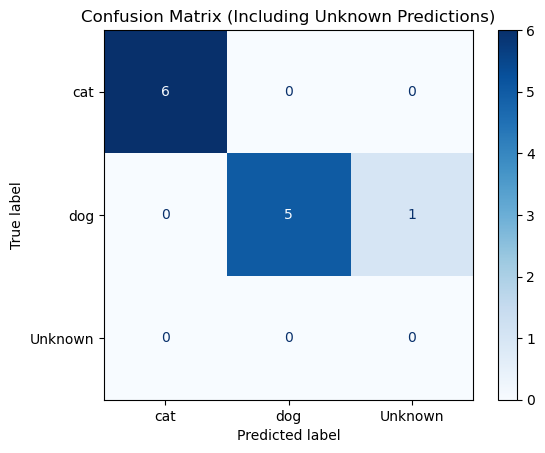

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = ["cat", "dog", "Unknown"]
cm = confusion_matrix(df["TrueLabel"], df["PredictedLabel"], labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Including Unknown Predictions)")
plt.show()



### Interpretation of "Unknown" Predictions

In some test cases, the model returned no predicted label, which we recorded as "Unknown".  
This usually occurs when the model is uncertain or the image is too different from the training distribution.

By including "Unknown" in the confusion matrix, we can better understand how often the model fails to classify unfamiliar images.

In our test set of 12 images, only one image was predicted as "Unknown", giving us a 91.67% accuracy overall.


In [68]:
#stop model
client.stop_project_version(ProjectVersionArn='arn:aws:rekognition:us-east-1:181786711311:project/CatDogClassifier-1/version/CatDogClassifier-1.2025-05-12T15.53.10/1747083190902')

{'Status': 'STOPPING',
 'ResponseMetadata': {'RequestId': '3484209c-f549-41b6-a9d5-b81137eb0348',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '3484209c-f549-41b6-a9d5-b81137eb0348',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '21',
   'date': 'Mon, 12 May 2025 21:56:42 GMT'},
  'RetryAttempts': 0}}

## Qualitative Error Analysis: Why Was This Image Predicted as "Unknown"?  
1. Low Contrast Between Subject and Background
The dog has a black and white coat, and the background is also grayscale (concrete, shadowed). This low-contrast setting may have made it harder for the model to detect edges and features.

2. Pose and Composition
The dog's face is turned slightly to the side, and its ears are pointed upright. These features may loosely resemble a cat, especially if the model is relying on ear shape, fur pattern, or face symmetry.

3. Facial Similarity to Cat Features
Husky dogs in particular have sharp eyes and triangular ears — traits that may confuse a model trained only on domestic, short-haired dogs and common cats.

In [69]:
unknowns = df[df["PredictedLabel"] == "Unknown"]
print(unknowns)

                               Image TrueLabel PredictedLabel  Confidence
6  data/cleaned_unseen/dog/img01.jpg       dog        Unknown         0.0


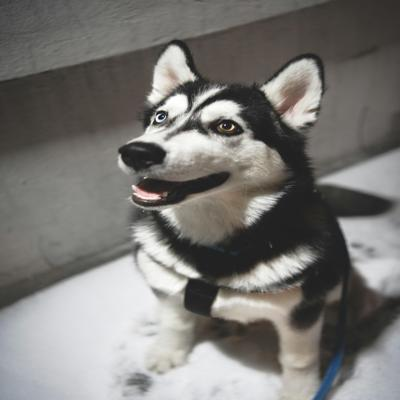

In [72]:
Image.open("cleaned_unseen/dog/img01.jpg")

## upload notebook and report to S3

In [ ]:
# upload notebook and screenshots to S3
s3_prefix='notebook'
file_name = "cv_pipeline.ipynb"
s3.upload_file(file_name, BUCKET, f"{s3_prefix}/{file_name}")

In [82]:
def upload_f(local_folder, s3_prefix):
    for file_name in Path(local_folder).glob("*"):
        s3.upload_file(str(file_name), BUCKET, f"{s3_prefix}/{file_name.name}")
upload_f('screenshots', "screenshots")

![jupyternotebook](upload_jn.png)
![screenshots](upload_scr.png)